In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score
from src.model_selection import test_model
from sklearn.metrics import confusion_matrix, mean_squared_error
from scipy.stats import pearsonr

In [2]:
from src.processing import import_data
from src.model_selection import test_model
from src.metrics import equalized_odds

# Load data

In [3]:
data_init, data_full, data, data_protected, data_y = import_data()

In [4]:
IsBlack = data_full.IsBlack == 1

In [5]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
index_cols = ["IsBlack"]

# DesicionTreeClassifier
## Baseline model

In [6]:
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)


model = DecisionTreeClassifier
model_params = {"max_depth":3, "random_state":1}

preds = test_model(model, X, y, kfold, model_params=model_params)

### Equalized odds regarding black ratio

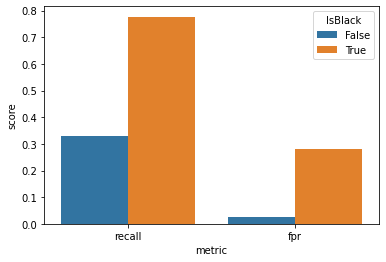

In [8]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
tmp_df = pd.concat([tmp_df_1, tmp_df_2])

sns.barplot(data=tmp_df, x="metric", y="score", hue="IsBlack")
plt.show()

In [9]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90      1411
           1       0.80      0.63      0.71       583

    accuracy                           0.85      1994
   macro avg       0.83      0.78      0.80      1994
weighted avg       0.84      0.85      0.84      1994



In [10]:
accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])

0.7559429477020603

In [11]:
accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])

0.8870139398385913

In [12]:
np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])

(395, 373.0)

In [13]:
np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])

(188, 90.0)

## Debias data baseline (desicion tree)

In [14]:
from src.debias_data import debias_data

In [15]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
protected_cols = ["racepctblack",
                      "racePctWhite", "racePctAsian", "racePctHisp"]
index_cols = ["IsBlack"]
nonprotected_cols = [col for col in data_full.columns if col not in protected_cols + y_cols + index_cols]

In [16]:
# Initialize X (with out the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [17]:
# Initialize the scaling and debiasing function
l_value = 0.0
scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)

In [18]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

model = DecisionTreeClassifier
model_params = {"random_state":1}

preds = test_model(model, X, y, kfold,scaler=scaler, model_params=model_params)

### Equalized odds regarding black ratio with unbias data

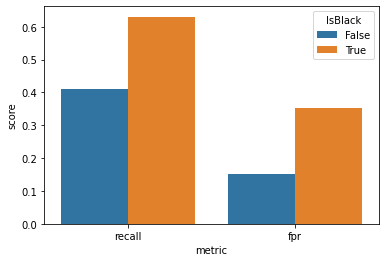

In [19]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
tmp_df = pd.concat([tmp_df_1, tmp_df_2])

sns.barplot(data=tmp_df, x="metric", y="score", hue="IsBlack")
plt.show()

In [20]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1411
           1       0.56      0.56      0.56       583

    accuracy                           0.74      1994
   macro avg       0.69      0.69      0.69      1994
weighted avg       0.74      0.74      0.74      1994



In [21]:
accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])

0.6370839936608558

In [22]:
accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])

0.7879677182685253

In [23]:
np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])

(395, 332.0)

In [24]:
np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])

(188, 255.0)

# Lambda loop

In [25]:
from tqdm import tqdm

In [26]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
protected_cols = ["racepctblack",
                      "racePctWhite", "racePctAsian", "racePctHisp"]
index_cols = ["IsBlack"]
nonprotected_cols = [col for col in data_full.columns if col not in protected_cols + y_cols + index_cols]

In [27]:
# Initialize X (with out the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [28]:
lambda_values = np.linspace(0,1,30)

In [29]:
predictions = {}
result_metrics = {}
for l_value in tqdm(lambda_values):
    scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    model = DecisionTreeClassifier
    model_params = {"random_state":1}

    preds = test_model(model, X, y, kfold,scaler=scaler, model_params=model_params)
    predictions[f"{l_value:.2f}"] = preds
    
    acc_black = accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])
    acc_non_black = accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
    recall_black, fpr_black = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
    recall_non_black, fpr_non_black = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
    num_high_black = np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])
    num_highn_non_black = np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])
    result_metrics[f"{l_value:.2f}"] = {"acc_black":acc_black,
                                        "acc_non_black": acc_non_black,
                                        "recall_black":recall_black, 
                                        "recall_non_black":recall_non_black,
                                         "fpr_black": fpr_black,
                                         "fpr_non_black": fpr_non_black,
                                        "num_high_black":num_high_black,
                                       "num_highn_non_black":num_highn_non_black}

100%|███████████████████████████████████████████| 30/30 [02:07<00:00,  4.24s/it]


In [30]:
makro_acc = []
equal_odds_mse = []
for key, res in result_metrics.items():
    m_acc = (res["acc_black"] + res["acc_non_black"])/2
    se_recall = (res["recall_black"]**2 - res["recall_non_black"]**2)
    se_fpr = (res["fpr_black"]**2 - res["fpr_non_black"]**2)
    mse_total = (se_recall + se_fpr)/2
    
    makro_acc.append(m_acc)
    equal_odds_mse.append(mse_total)

Text(0, 0.5, 'Mean squerred difference in equalized odds')

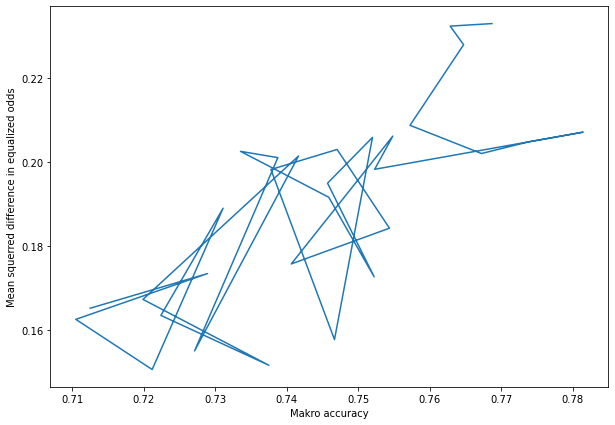

In [31]:
fig, ax = plt.subplots(1, figsize=(10,7))
plt.plot(makro_acc, equal_odds_mse)
plt.xlabel("Makro accuracy")
plt.ylabel("Mean squerred difference in equalized odds")

# LogisticRegression
## Baseline model

In [32]:
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [33]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)


model = LogisticRegression
model_params = {"max_iter":500, "random_state":1}

preds = test_model(model, X, y, kfold, model_params=model_params)

### Equalized odds regarding black ratio

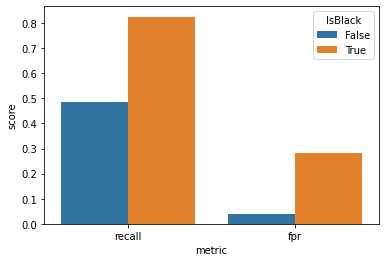

In [34]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
tmp_df = pd.concat([tmp_df_1, tmp_df_2])

sns.barplot(data=tmp_df, x="metric", y="score", hue="IsBlack")
plt.show()

In [35]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1411
           1       0.79      0.72      0.75       583

    accuracy                           0.86      1994
   macro avg       0.84      0.82      0.83      1994
weighted avg       0.86      0.86      0.86      1994



In [36]:
accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])

0.7844690966719493

In [37]:
accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])

0.896551724137931

In [38]:
np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])

(395, 393.0)

In [39]:
np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])

(188, 135.0)

## Debias data baseline (logreg)

In [40]:
from src.debias_data import debias_data

In [41]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
protected_cols = ["racepctblack",
                      "racePctWhite", "racePctAsian", "racePctHisp"]
index_cols = ["IsBlack"]
nonprotected_cols = [col for col in data_full.columns if col not in protected_cols + y_cols + index_cols]

In [42]:
# Initialize X (with out the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [43]:
# Initialize the scaling and debiasing function
l_value = 0.0
scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)

In [44]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

model = LogisticRegression
model_params = {"max_iter":500, "random_state":1}

preds = test_model(model, X, y, kfold,scaler=scaler, model_params=model_params)

### Equalized odds regarding black ratio with unbias data

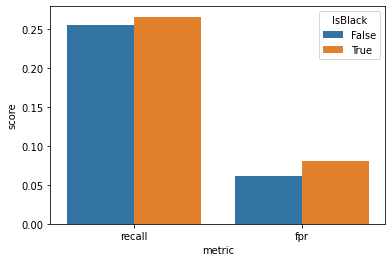

In [45]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
tmp_df = pd.concat([tmp_df_1, tmp_df_2])

sns.barplot(data=tmp_df, x="metric", y="score", hue="IsBlack")
plt.show()

In [46]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.75      0.94      0.84      1411
           1       0.63      0.26      0.37       583

    accuracy                           0.74      1994
   macro avg       0.69      0.60      0.60      1994
weighted avg       0.72      0.74      0.70      1994



In [47]:
accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])

0.5103011093502378

In [48]:
accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])

0.8444607483492297

In [49]:
np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])

(395, 124.0)

In [50]:
np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])

(188, 120.0)

# Lambda loop

In [51]:
from tqdm import tqdm

In [52]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
protected_cols = ["racepctblack",
                      "racePctWhite", "racePctAsian", "racePctHisp"]
index_cols = ["IsBlack"]
nonprotected_cols = [col for col in data_full.columns if col not in protected_cols + y_cols + index_cols]

In [53]:
# Initialize X (with out the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [54]:
lambda_values = np.linspace(0,1,30)

In [55]:
predictions = {}
result_metrics = {}
for l_value in tqdm(lambda_values):
    scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    model = LogisticRegression
    model_params = {"max_iter":500, "random_state":1}

    preds = test_model(model, X, y, kfold,scaler=scaler, model_params=model_params)
    predictions[f"{l_value:.2f}"] = preds
    
    acc_black = accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])
    acc_non_black = accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
    recall_black, fpr_black = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
    recall_non_black, fpr_non_black = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
    num_high_black = np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])
    num_highn_non_black = np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])
    result_metrics[f"{l_value:.2f}"] = {"acc_black":acc_black,
                                        "acc_non_black": acc_non_black,
                                        "recall_black":recall_black, 
                                        "recall_non_black":recall_non_black,
                                         "fpr_black": fpr_black,
                                         "fpr_non_black": fpr_non_black,
                                        "num_high_black":num_high_black,
                                       "num_highn_non_black":num_highn_non_black}

100%|███████████████████████████████████████████| 30/30 [01:52<00:00,  3.75s/it]


In [56]:
makro_acc = []
equal_odds_mse = []
for key, res in result_metrics.items():
    m_acc = (res["acc_black"] + res["acc_non_black"])/2
    se_recall = (res["recall_black"]**2 - res["recall_non_black"]**2)
    se_fpr = (res["fpr_black"]**2 - res["fpr_non_black"]**2)
    mse_total = (se_recall + se_fpr)/2
    
    makro_acc.append(m_acc)
    equal_odds_mse.append(mse_total)

Text(0, 0.5, 'Mean squerred difference in equalized odds')

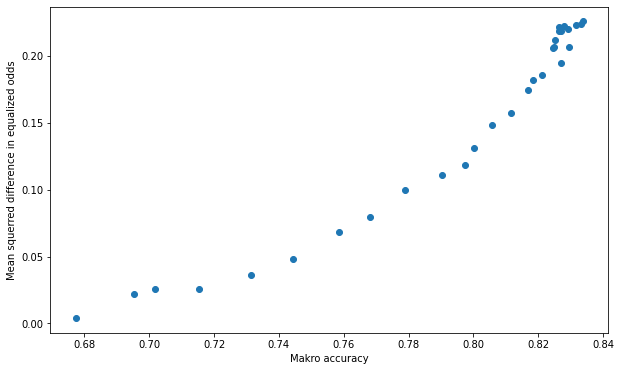

In [59]:
fig, ax = plt.subplots(1, figsize=(10,6))
plt.scatter(makro_acc, equal_odds_mse)
plt.xlabel("Makro accuracy")
plt.ylabel("Mean squerred difference in equalized odds")